# Divide ROI with fiber innervation
This notebook divide ROIs using fiber innervation data of Allen Institute for Brain Science (AIBS). In this example, we used a fiber innervation from agranular insula to Caudoputamen.

- input
    - AVbase_d_g.nrrd
- outputs
    - figures to demonstrate ROI segmentation
    - annotation volume that have ROIs with high or low fiber innervation in the target ROI

In [1]:
Target_ROI_ID = 672 # Caudoputamen, voxel count 26040
Fiber_from ='AI' # injection structure in ID or acronym
Fiber_to = 'CP' # Caudoputamen, id 672, target structure in ID or acronym

dir_data = 'data'
dir_fig = 'figs'
dir_fiber = 'fiber_data\\From_AI_To_CP\\'

fn_input_AV = 'AVbase_c_g.nrrd'

In [25]:
fn_output_fig_fiberinnervation = 'fiber_from_'+str(Fiber_from)+'_to_'+str(Fiber_to)+'.png'
fn_output_fig_target_ROI = 'target_ROI_fiber_'+str(Target_ROI_ID)+'.png'
fn_output_fig_fiberinnervation_in_target_ROI = 'fiber_in_target_ROI_'+str(Target_ROI_ID)+'_fiber_from_'\
    +str(Fiber_from)+'_to_'+str(Fiber_to)+'.png'
fn_output_fig_histogram_fiber = 'fiber_histogram_TargetROI_'+str(Target_ROI_ID)+'_From_'\
    +str(Fiber_from)+'_to_'+str(Fiber_to)+'.png'

fn_output_AV_target_ROI_fiber_HighLow =\
    'AV_target_ROI_ID_'+str(Target_ROI_ID)+\
    '_fiber_from_'+str(Fiber_from)+'_to_'+str(Fiber_to)+'.nrrd'

In [24]:
import os
# from allensdk.api.queries.grid_data_api import GridDataApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
import glob
import pandas as pd
from pprint import pprint
import skimage.io as io
import numpy as np
import nrrd
import matplotlib.pyplot as plt
import copy
from scipy import optimize
%matplotlib inline

# just used for displaying data
SliceIdx = 84
CoronalIdx = np.linspace(43,53,3) # 43, 48, 53
# fiber data: spacing 100 um, 132 slices from anterior to posterior
# 132 -[43,48,53] = 89, 84, 79 from posterior to anterior
# [89, 84, 79] - 78 = 11, 6, 1 * 100 um

# Load data

## annotation volume

In [26]:
AV, header = nrrd.read(os.path.join(dir_data, fn_input_AV))
AV_targetROI = AV == Target_ROI_ID

## fiber innervation

In [27]:
mcc = MouseConnectivityCache(resolution = 100, manifest_file=os.path.join\
 (dir_fiber,'mouse_connectivity_manifest.json'))

mca = MouseConnectivityApi()
Fiber_experiments = mca.experiment_source_search(injection_structures=Fiber_from,\
                                                 target_domain=Fiber_to, \
                                                 primary_structure_only=True)

Mat_pd, pd_info = mcc.get_projection_density(Fiber_experiments[0]['id'])
Mat_pd = Mat_pd[:,:,:,np.newaxis] # assign new axis for concatanation

for i in range(1, len(Fiber_experiments)):
    if Fiber_experiments[i]['injection-coordinates'][2] > 5700: # to retrieve only right injection
         experiment_id = Fiber_experiments[i]['id']
         pd, pd_info = mcc.get_projection_density(experiment_id);
         temp_pd = pd[:,:,:,np.newaxis]
         Mat_pd = np.concatenate([Mat_pd, temp_pd], axis=3) # (132,80, 114, 25)

Mat_pd_average = np.average(Mat_pd, axis = 3)
Mat_pd_average_flipped = np.flip(Mat_pd_average, axis=2) # .shape (132, 80, 114)
Mat_pd_average_RR = np.concatenate((Mat_pd_average_flipped[:,:,0:57],\
                           Mat_pd_average[:,:,-57:]), axis=2)
img_fiber_only_in_targetROI_mean_RR = Mat_pd_average_RR * AV_targetROI

Mat_pd_max = np.amax(Mat_pd, axis = 3)
Mat_pd_max_flipped = np.flip(Mat_pd_max, axis=2) # .shape (132, 80, 114)
Mat_pd_max_RR = np.concatenate((Mat_pd_max_flipped[:,:,0:57],\
                           Mat_pd_max[:,:,-57:]), axis=2)
img_fiber_only_in_targetROI_max_RR = Mat_pd_max_RR * AV_targetROI

# Check loaded data

In [28]:
slices = [int(x) for x in CoronalIdx.round()]

## Target ROI

Target ROI ID: 672


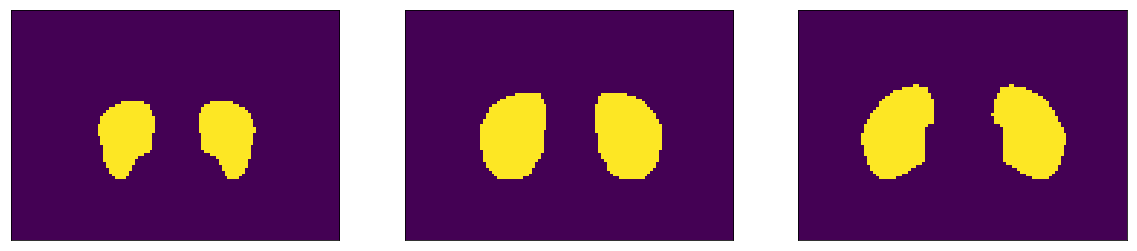

In [29]:
print('Target ROI ID: '+str(Target_ROI_ID))

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

fig1, ax1 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    ax1[count].imshow(AV_targetROI[idx,:,:], aspect='equal')
    ax1[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

## Fiber innervation

In [30]:
all_experiments = mcc.get_experiments(dataframe=True)
print('Total experiments: %d' % len(all_experiments)) # total experiments 2995
print('Experiments of fiber innervation from {} to {}: {}'\
      .format(Fiber_from, Fiber_to, len(Fiber_experiments)))
print('Injection at right hemisphere: {}'.format(Mat_pd.shape[3]))

Total experiments: 2995
Experiments of fiber innervation from AI to CP: 27
Injection at right hemisphere: 25


### Representative data

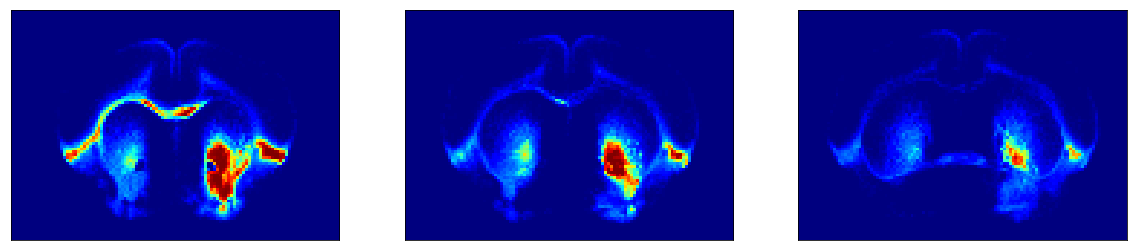

In [31]:
representative_idx = 1

fig2, ax2 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H2 = ax2[count].imshow(Mat_pd[idx,:,:,representative_idx],\
                          aspect='equal', cmap='jet', vmin=0, vmax=1)
    ax2[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

### Bilateral data of mean fiber innervation

mean projection density of bilateral fiber innervation


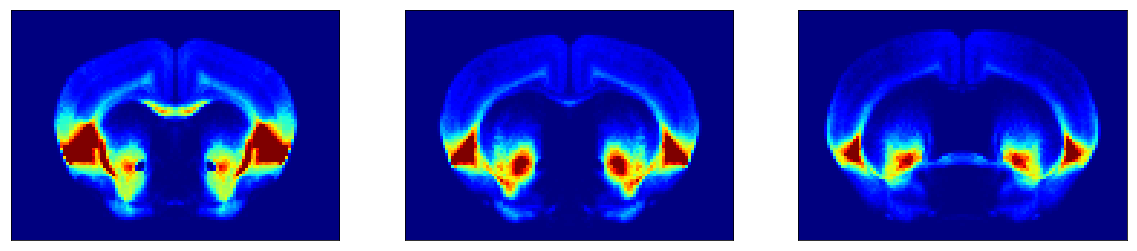

In [32]:
print('mean projection density of bilateral fiber innervation')

fig3, ax3 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H3 = ax3[count].imshow(Mat_pd_average_RR[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=0.15)
    ax3[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

### Bilateral data of max fiber innervation

max projection density of bilateral fiber innervation


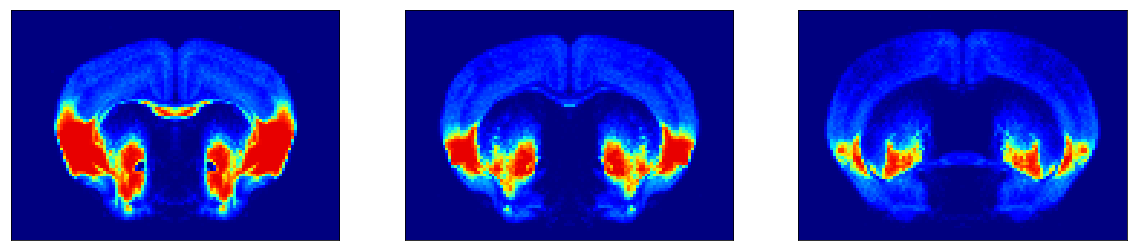

In [33]:
print('max projection density of bilateral fiber innervation')

fig4, ax4 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H6 = ax4[count].imshow(Mat_pd_max_RR[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=1.1)
    ax4[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

## Fiber innervation in target ROI

### Representative data

Fiber innervation only in the target ROI, 672
Fiber from AI to CP


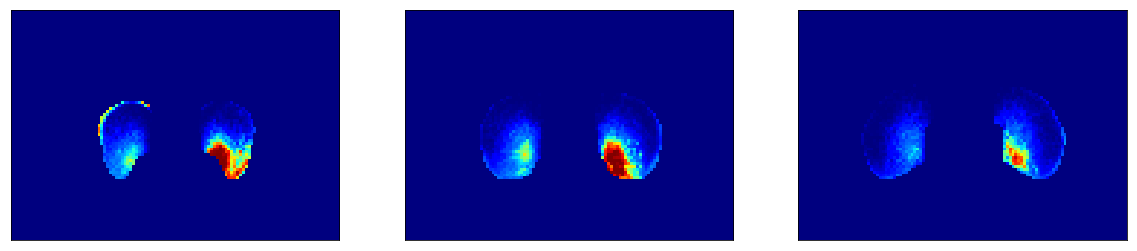

In [34]:
print('Fiber innervation only in the target ROI, '+str(Target_ROI_ID))
print('Fiber from '+str(Fiber_from)+' to '+str(Fiber_to))

img_fiber_only_in_targetROI_representative = Mat_pd[:,:,:,representative_idx] * AV_targetROI
fig5, ax5 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H3 = ax5[count].imshow(img_fiber_only_in_targetROI_representative[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=1)
    ax5[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

### Mean data

mean projection density


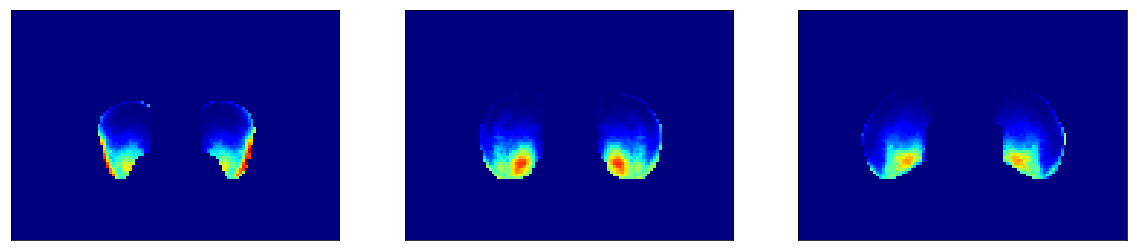

In [35]:
print('mean projection density')
fig6, ax6 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H3 = ax6[count].imshow(img_fiber_only_in_targetROI_mean_RR[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=.2)
    ax6[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

### Bilateral max data

Fiber innervation only in the target ROI, 672
Fiber from AI to CP


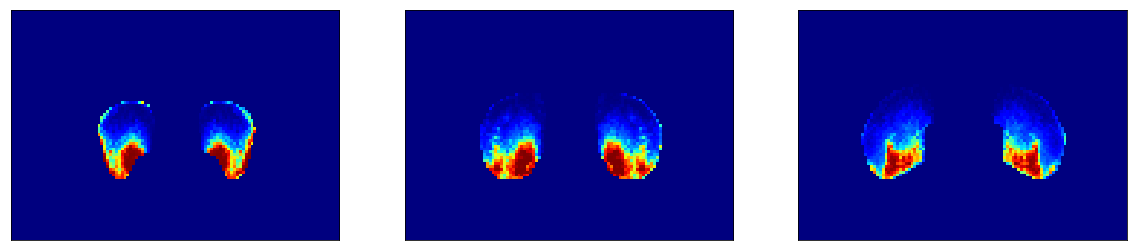

In [36]:
print('Fiber innervation only in the target ROI, '+str(Target_ROI_ID))
print('Fiber from '+str(Fiber_from)+' to '+str(Fiber_to))

fig7, ax7 = plt.subplots(1,len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H7 = ax7[count].imshow(img_fiber_only_in_targetROI_max_RR[idx,:,:],\
                           aspect='equal', cmap='jet', vmin=0, vmax=1)
    ax7[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

# Plot histogram of fiber innervation in a target ROI

In [37]:
hist, bin_edges = np.histogram(\
img_fiber_only_in_targetROI_max_RR\
[np.logical_and(img_fiber_only_in_targetROI_max_RR != 0,\
                img_fiber_only_in_targetROI_max_RR < 0.98)], bins=60)

['ttt.shape', (132, 80, 114)]
['ttt.size', 1203840]
['ttt2.shape', (26038,)]


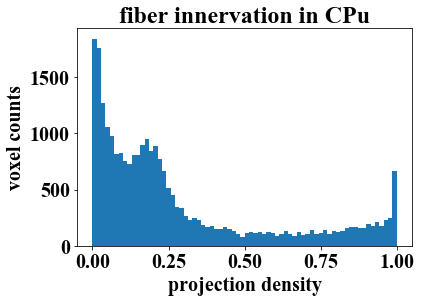

In [38]:
ttt = img_fiber_only_in_targetROI_max_RR != 0
pprint(['ttt.shape', ttt.shape])
pprint(['ttt.size', ttt.size])
ttt2 = img_fiber_only_in_targetROI_max_RR[ttt]
pprint(['ttt2.shape', ttt2.shape])

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(1,1,1)
y, ind, pacthes = ax.hist(ttt2, bins=70) # ind is edges of the bins = length nbins + 1
# ax.axvline(x=10, color='w', linewidth=1, linestyle='--')
ax.set_title('fiber innervation in CPu')
ax.set_xlabel('projection density')
ax.set_ylabel('voxel counts')
fig.show()

## Fit with exponential and normal distriburion

In [39]:
center_ind = (bin_edges[:-1] + bin_edges[1:])/2

def NormalDistri(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def ExpoDistri(x, height, rate, offset):
    return height*np.exp(-rate*x) + offset
def two_LogNormal(x, h1, c1, w1, h2, c2, w2, offset):
    return (LogNormal(x, h1, c1, w1, offset=0) + LogNormal(x, h2, c2, w2, offset=0) + offset)
def Normal_Expo(x, h1, c1, w1, h2, rate, offset):
    return (NormalDistri(x, h1, c1, w1, offset=0) + ExpoDistri(x, h2, rate, offset=0) + offset)

# errfunc1 = lambda p, x, y: (NormalDistri(x, *p) - y)**2
# errfunc2 = lambda p, x, y: (ExpoDistri(x, *p) - y)**2
errfunc3 = lambda p, x, y: (Normal_Expo(x, *p) - y)

# guess1 = [700, 0.2, 0.15, 100]
# guess2 = [1500, 6, 126]
# guess3 = np.array([200, 0.2, 0.07, 3000, 20, 80])
guess3 = [770, 0.17, 0.09, 2000, 20, 80]
# optim1, success1 = optimize.leastsq(errfunc1, guess1, args=(center_ind, hist))
# optim1, success1 = optimize.leastsq(errfunc1, guess1[:], args=(center_ind, hist))
# optim2, success2 = optimize.leastsq(errfunc2, guess2[:], args=(center_ind, hist))
optim3, success3 = optimize.leastsq(errfunc3, guess3[:], args=(center_ind, hist))

In [40]:
# get an inflection point of the fit curve
# y_prime = np.gradient(hist)
# indices = np.where(np.diff(np.sign(y_prime)))[0]
# inflections = center_ind[indices]# [ 1.9, 10.2, 11.4, 17.3, 18.4, 32.6]
# Thr_fiber = inflections[0]

# get intersection of two fitting functions
eval_func = lambda x: (NormalDistri(x, *optim3[0:3],0) -ExpoDistri(x, *optim3[3:5], 0))
ini_x1 = 0
ini_x2 = 0.3
for i in range(30):
    half = (ini_x1 + ini_x2) / 2
    val = eval_func(half)
    if val < 0:
        ini_x1 = half
    else:
        ini_x2 = half
Thr_fiber = (ini_x1 + ini_x2)/2


In [41]:
Thr_fiber

0.07536620157770813

## plot histogram of fiber innervation

Fiber innervation only in the target ROI, 672
Fiber from AI to CP
Threshold for fiber innervation: 0.08


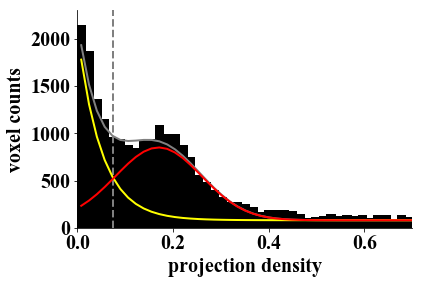

In [42]:
print('Fiber innervation only in the target ROI, '+str(Target_ROI_ID))
print('Fiber from '+str(Fiber_from)+' to '+str(Fiber_to))
print('Threshold for fiber innervation: %2.2f' % Thr_fiber)

fig8, ax8 = plt.subplots(facecolor='w')
ax8.bar(center_ind, hist, width = 0.02, color='black') # energy data
#ax8.plot(center_ind, NormalDistri(center_ind, *optim1), lw=4, c='green', ls='--')
#ax8.plot(center_ind,ExpoDistri(center_ind, *optim2), lw=2, c='red', ls='--') # doubne log normal fit
ax8.plot(center_ind, Normal_Expo(center_ind, *optim3), lw=4, c='gray', ls='-')
ax8.axvline(x=Thr_fiber, color='gray', linewidth=4, linestyle='--', label='3sd')
ax8.plot(center_ind, ExpoDistri(center_ind, *optim3[-3:]), lw=2, c='Yellow')
ax8.plot(center_ind, NormalDistri(center_ind, *optim3[0:3], optim3[-1]), lw=2, c='red', ls='-')
ax8.spines['right'].set_color('none')
ax8.spines['top'].set_color('none')
ax8.set_xlim(0,0.7)
ax8.set_ylim(0,2300)
ax8.set_xlabel('projection density')
ax8.set_ylabel('voxel counts');

# Divide a target ROI with fiber innervation

In [43]:
img_fiber_only_in_targetROI_max_RR_High = (img_fiber_only_in_targetROI_max_RR >= Thr_fiber)\
* (img_fiber_only_in_targetROI_max_RR - Thr_fiber)

img_fiber_only_in_targetROI_max_RR_Low = (img_fiber_only_in_targetROI_max_RR < Thr_fiber)\
* (img_fiber_only_in_targetROI_max_RR != 0)\
* (img_fiber_only_in_targetROI_max_RR - Thr_fiber)

img_fiber_HighLow = img_fiber_only_in_targetROI_max_RR_High\
+ img_fiber_only_in_targetROI_max_RR_Low

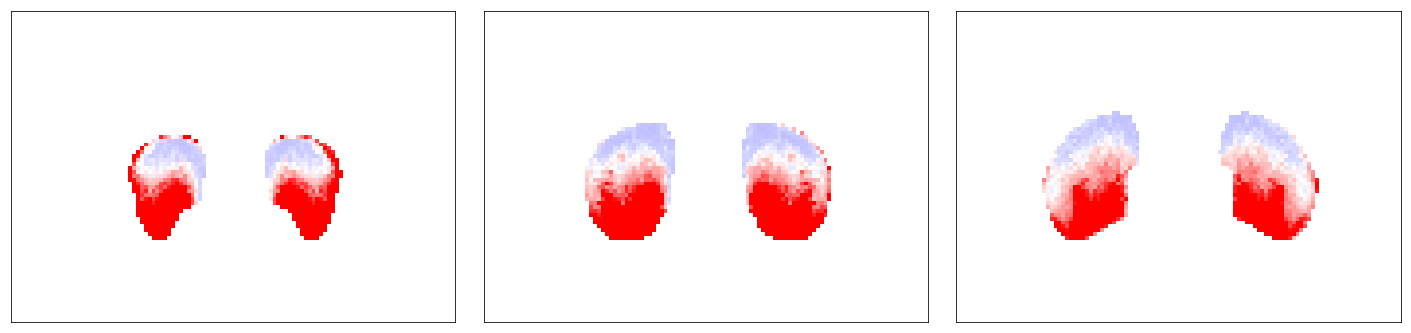

In [44]:
fig9, ax9 = plt.subplots(1, len(CoronalIdx), figsize=(20,28), facecolor='w')
for count, idx in enumerate(slices):
    H9 = ax9[count].imshow(img_fiber_HighLow[idx,:,:], aspect='equal',\
                          cmap='bwr', vmin=-0.3, vmax=0.3)
    ax9[count].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
fig9.tight_layout()

# Save

## fig

In [45]:
fig1.savefig(os.path.join(dir_fig,fn_output_fig_target_ROI),\
             dpi=300, bbox_inches='tight')
fig2.savefig(os.path.join(dir_fig, fn_output_fig_fiberinnervation),\
             dpi=300, bbox_inches='tight')
fig8.savefig(os.path.join(dir_fig, fn_output_fig_histogram_fiber),\
            dpi=300, bbox_inches='tight')
fig9.savefig(os.path.join(dir_fig, fn_output_fig_fiberinnervation_in_target_ROI),\
            dpi=300, bbox_inches='tight')

## AV that contains a ROI with more innervation and a ROI with less innervation

In [46]:
nrrd.write(os.path.join(dir_data, fn_output_AV_target_ROI_fiber_HighLow),\
          img_fiber_HighLow, header)